In this notebook we will take the iris dataset and try to do unsupervised clustering of two flowers, based on their petal width.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from IPython.core.pylabtools import figsize
import pymc3 as pm
import theano.tensor as T

# import iris dataset
iris = datasets.load_iris()

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print (list(iris.feature_names))
print (list(iris.target_names))

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa', 'versicolor', 'virginica']


In [4]:
y = iris.target                    
x = iris.data                      
df_target = pd.DataFrame(y)   
df_data = pd.DataFrame(x)

df_target.columns = ['flower']
df_data.columns = ['sepal length', 'sepal width', 'petal length', 'petal width']

# join the 2 datasets into one dataframe
df = df_data.join(df_target, how='left')
df.head()

,sepal length,sepal width,petal length,petal width,flower
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


**Scale petal_width to larger values because small standard deviations very close to zero will create an error.**

In [5]:
# Multiple by 100
df['petal width'] = df['petal width']*100

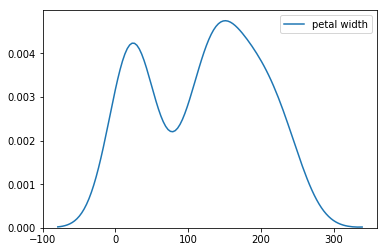

In [6]:
petal_width = df['petal width']
sns.kdeplot(petal_width)
plt.show()

In [7]:
df.groupby('flower')['petal width'].std()

flower
0    10.720950
1    19.775268
2    27.465006
Name: petal width, dtype: float64

In [8]:
df.groupby('flower')['petal width'].mean()

flower
0     24.4
1    132.6
2    202.6
Name: petal width, dtype: float64

**Let's take the setosa flower (0) out for now, so that we can model an unsupervised clustering of two clusters: versicolor (1) and virginica (2)**

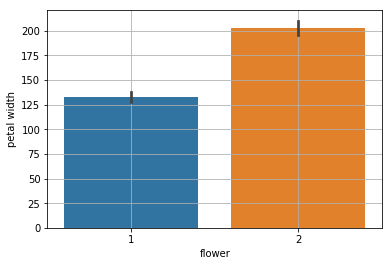

In [10]:
two_flowers = df.copy()
two_flowers = two_flowers[(two_flowers.flower==1)|(two_flowers.flower==2)]
sns.barplot(two_flowers.flower, two_flowers['petal width'])
plt.grid()

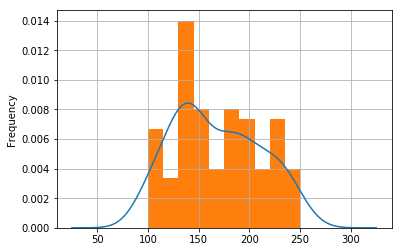

In [11]:
two_flowers['petal width'].plot(kind='kde')
two_flowers['petal width'].plot(kind='hist', normed=True, bins=10)
plt.grid()
plt.show()

Assuming we don't know the which flower each petal width belongs to, it looks like we have two clusters: around 120-150 and 180-200

The mode appears to hover around 120-140


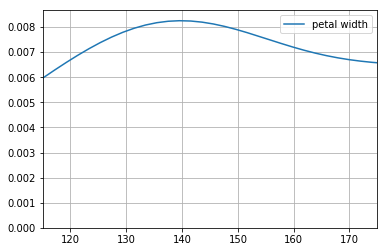

In [15]:
sns.kdeplot(two_flowers['petal width'])
plt.savefig("petal_width")
plt.xlim(115,175)
plt.grid()
print ("The mode appears to hover around 120-140")

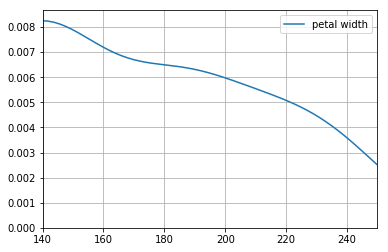

The 2nd mode appears to hover around 120-140


In [17]:
sns.kdeplot(two_flowers['petal width'])
plt.xlim(140,250)
plt.grid()
plt.show()
print ("The 2nd mode appears to hover around 120-140")

**Let try to approximate those clusters**

In [18]:
data = two_flowers['petal width']

In [19]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)    # probability data assigned to cluster 1
    p2 = 1 - p1                   # probability data assigned to cluster 2
    p = T.stack([p1, p2])         # creates a vector that pymc3/theano can work with
    
    # after tracing, each of the 100 datapoints will have thousands of 'assignment' samples of either 0 or 1, 
    # based on the likelihood of them being 0 or 1. The trace['assignment'][:,8].mean() will give us the probability 
    # that the category/cluster for the 8th datapoint is equal to 1
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, size=data.shape[0])) #create 100 values with 0 or 1

In [20]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)    # prior distribution of the standard deviations for the two clusters
#     centers = pm.Normal("centers",              # prior distribution of the  means for the two clusters
#                         mu=np.array([140, 190]), 
#                         sd=np.array([10, 10]), 
#                         shape=2)
    centers = pm.Uniform("centers",
                         lower=np.array([120,190]), # prior distribution of the  means for the two clusters
                         upper=np.array([140,210]),
                         shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])# Mean for each datapoint out of 300, depending on ass.
    sd_i = pm.Deterministic('sd_i', sds[assignment])            # Std for each datapoint out of 300, depending on ass.
    
    # likelihood of observed data, given mu and std of each datapoint
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data) 
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [1 1 0 1] ...
Assigned center:  [200. 200. 130. 200.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


In [21]:
with model:
#     step1 = pm.Metropolis(vars=[p, sds, centers])
#     step2 = pm.ElemwiseCategorical(vars=[assignment])
#     trace = pm.sample(25000, step=[step1, step2], njobs=1)
    trace = pm.sample(15000, tune=13500, njobs=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [centers_interval__, sds_interval__, p_interval__]
>BinaryGibbsMetropolis: [assignment]
100%|████████████████████████████████████████████████████████████████████████████| 28500/28500 [08:23<00:00, 56.55it/s]
The number of effective samples is smaller than 25% for some parameters.


In [22]:
print(trace['assignment'].shape)
print(trace['p'].shape)
print(trace['sd_i'].shape)
print(trace['center_i'].shape)
print(trace['centers'].shape)
print(trace['sds'].shape)

(30000, 100)
(30000,)
(30000, 100)
(30000, 100)
(30000, 2)
(30000, 2)


In [23]:
pm.summary(trace, varnames=['centers','sds'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
centers__0,132.339175,3.904554,0.058476,125.612310,139.953912,5150.492875,1.000179
centers__1,200.267938,5.313399,0.085375,191.122847,209.643271,3998.790317,1.000239
sds__0,20.836767,3.336557,0.053532,14.931302,27.590403,4712.017170,0.999968
sds__1,30.267065,4.934375,0.075898,21.073556,39.819518,4023.492381,1.000202


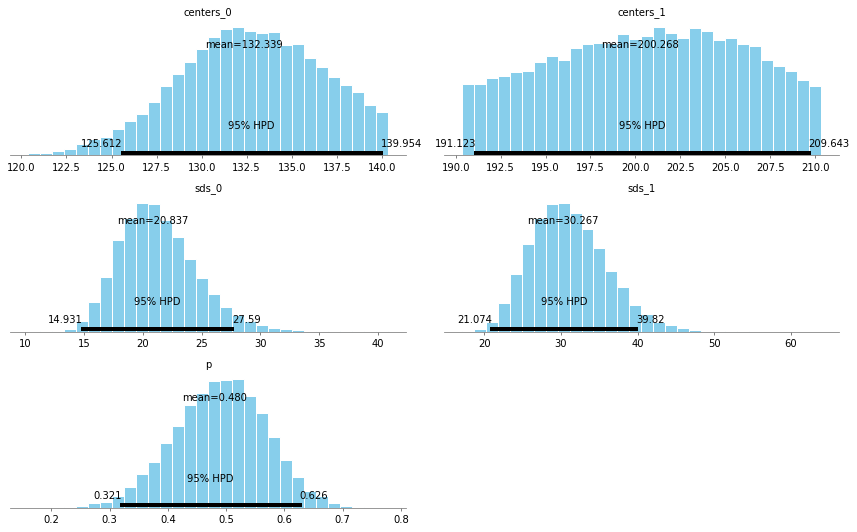

In [24]:
pm.plot_posterior(trace, varnames=['centers','sds','p'], color='#87ceeb') 
plt.show()

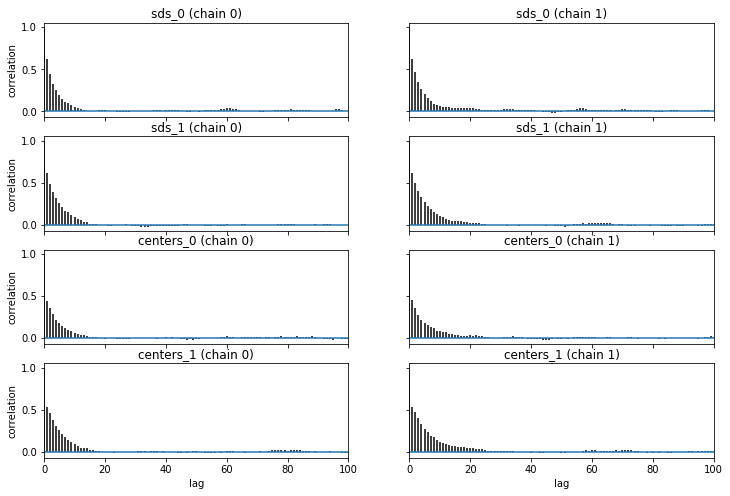

In [25]:
pm.plots.autocorrplot(trace=trace, varnames=["sds",'centers'])
plt.show()

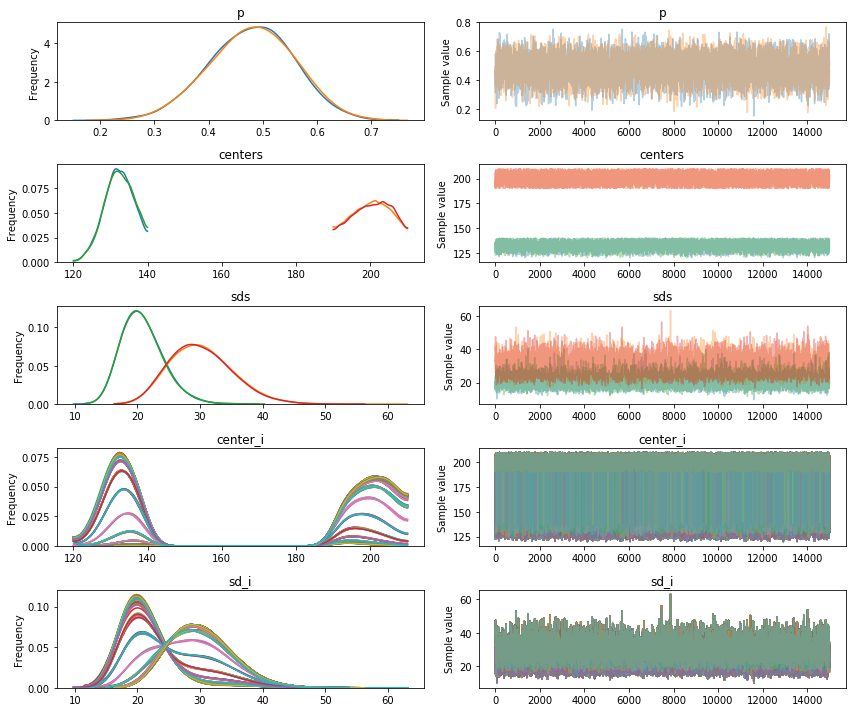

In [26]:
pm.traceplot(trace, varnames=['p','centers','sds','center_i','sd_i'])
plt.show()

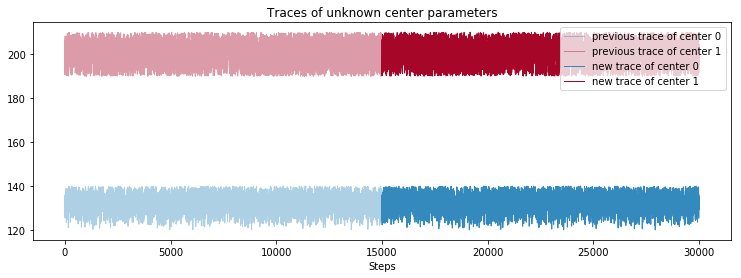

In [27]:
# Compare visualizations between early posterior samples and more recent ones
figsize(12.5, 4)
lw = 1
center_trace = trace["centers"][15000:]
prev_center_trace = trace["centers"][:15000]

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

x = np.arange(15000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(15000, 30000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

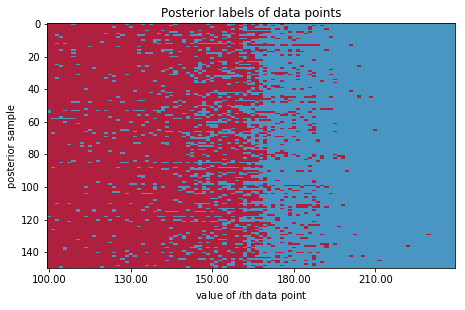

In [56]:
import matplotlib as mpl
plt.cmap = mpl.colors.ListedColormap(colors)
plt.figure(figsize=(12.5, 4.5))

# trace['assignment'] has 30,000 rows as samples and 100 columns as datapoints for each value in the orginal data
# Below, slice the trace, so it extracts a sample every 200 jumps (30,000samples/200=150, also known as thinning)
# with all the columns/datapoints. But first, sort the datapoints' index from smallest to largest values, 
# so the first sample extracted is for column/datapoint that has the lowest value (100) 
plt.imshow(trace["assignment"][::200, np.argsort(data)], 
           cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 20),
       ["%.2f" % s for s in np.sort(data)[::20]])  #slice the x.ticks to show different values 
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points")
plt.show()

Above we see that when petal_width is 130 it is mainly red (belonging to cluster 0), but when it is around 160 it is difficult to tell the probability of belonging to either cluser.

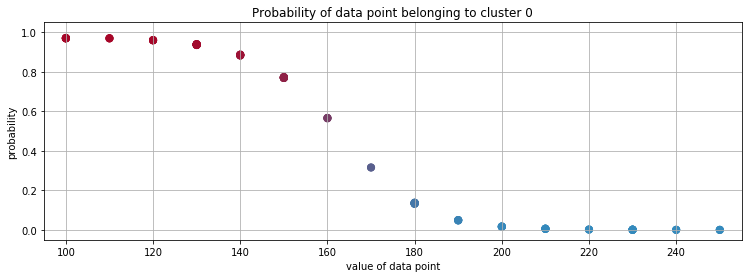

In [36]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]

# for datapoint(value=160), 1- (assign_trace[:,1].mean()) is 56%. 
# axis=0 refers to columns/datapoints as opposed to rows/samples; 
# thus, the plot below calculates mean for each of the 300 datapoints
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(95, 255)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")
plt.grid();

http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb#Returning-to-Clustering:-Prediction

**Taking into consideration the mean and the std, what is the probability of X datapoint value to belong to cluster 1?** (for the two cells above, we only considered the mean when calculating probabilities, which is less accurate then using both mean and std.)

In [68]:
norm_pdf = stats.norm.pdf

p_trace = trace["p"][25000:]            # drop the burn-in period  
prev_p_trace = trace["p"][:25000]      
std_trace = trace["sds"][25000:]        # drop the burn-in period
center_trace = trace["centers"][25000:] # drop the burn-in period

x = 163

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) < \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())
print ("Cutoff seems to be around the 163 pedtal-width mark")

Probability of belonging to cluster 1: 0.5246
Cutoff seems to be around the 163 pedtal-width mark


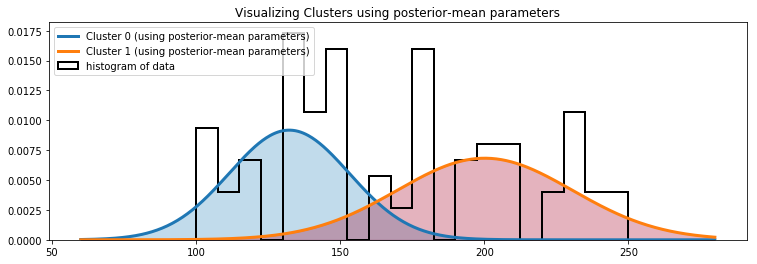

In [69]:
norm = stats.norm
x = np.linspace(60, 280, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()           # % of datapoints assigend to cluster 0 

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")

#for y axis of orginal data to be proportional to y axis of posterior means, we need to multiply posterior 
# means of cluster 0 by the pdf of the posterior means of cluster 0
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)


y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

In [139]:
testing = two_flowers[['petal width','flower']]
testing[(testing.flower==1) & (testing['petal width']>162)]
print("accuracy rate for predicting flower 1, cluster 0, based on petal width: "+ str(1-(2/50)))

testing[(testing.flower==2) & (testing['petal width']<163)]
print("accuracy rate for predicting flower 2, cluster 1, based on petal width: "+ str(1-(4/50)))

accuracy rate for predicting flower 1, cluster 0, based on petal width: 0.96
accuracy rate for predicting flower 2, cluster 1, based on petal width: 0.92
